In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

import theano
import theano.tensor as T
import pymc3 as pm
theano.config.optimizer_including

from io import StringIO
import sys


In [2]:
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[10,1,10], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 

Active grids: ['regular']


In [3]:
geo_data.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Default series,1,False,#015482,1
1,rock1,Default series,2,False,#9f0052,2
2,basement,Basement,1,True,#ffbe00,3


In [4]:
geo_data.delete_surface_points([1, 3, 4, 5, 7, 9, 10, 11])

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,100,200,600,0.2501,0.3126,0.5626,rock2,Default series,1,1,1.000000e-08
2,900,200,600,0.7501,0.3126,0.5626,rock2,Default series,1,1,1.000000e-08
6,100,200,400,0.2501,0.3126,0.4376,rock1,Default series,2,1,1.000000e-08
8,900,200,400,0.7501,0.3126,0.4376,rock1,Default series,2,1,1.000000e-08


In [5]:
geo_data.modify_surface_points([0,2,6,8], Y=500)

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,100,500,600,0.2501,0.5001,0.5626,rock2,Default series,1,1,1.000000e-08
2,900,500,600,0.7501,0.5001,0.5626,rock2,Default series,1,1,1.000000e-08
6,100,500,400,0.2501,0.5001,0.4376,rock1,Default series,2,1,1.000000e-08
8,900,500,400,0.7501,0.5001,0.4376,rock1,Default series,2,1,1.000000e-08


In [6]:
geo_data.delete_orientations(1)

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,500,500,600,0.5001,0.5001,0.5626,1.000000e-12,1.000000e-12,1.0,0,90,1,rock2,Default series,1,1,0.01


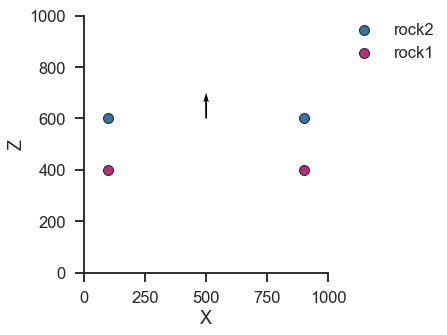

In [7]:
gp.plot.plot_data(geo_data)

In [8]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_compile',
                         verbose=['n_surface_op_float_sigmoid', 'compare'])

Compiling theano function...
Compilation Done!


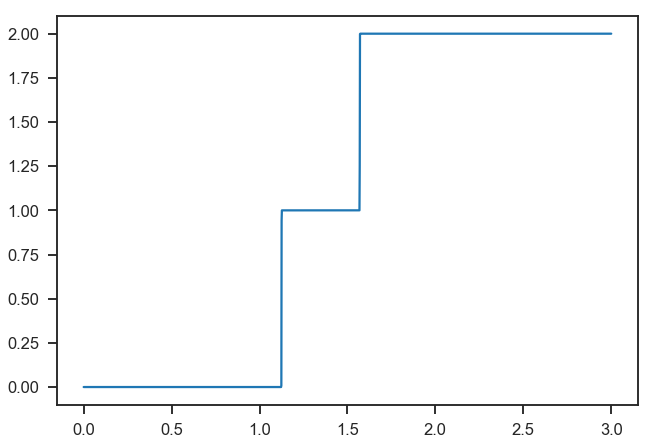

In [9]:


def plot_sig(n_surface_0 = -1, n_surface_1 = 1, l = 50, Z_x = np.linspace(0, 3, 2000),
             a = 1.57, b = 1.125, drift = 1):

    f_x = -n_surface_0 / (1 + np.exp(-l * (Z_x - a))) - \
                   (n_surface_1 / (1 + np.exp(l * (Z_x - b)))) + drift
    plt.plot(Z_x, f_x)

    
plot_sig(n_surface_0 = -1, n_surface_1 = 1, l = 5000, Z_x = np.linspace(0, 3, 2000),
             a = 1.57, b = 1.125, drift = 1)

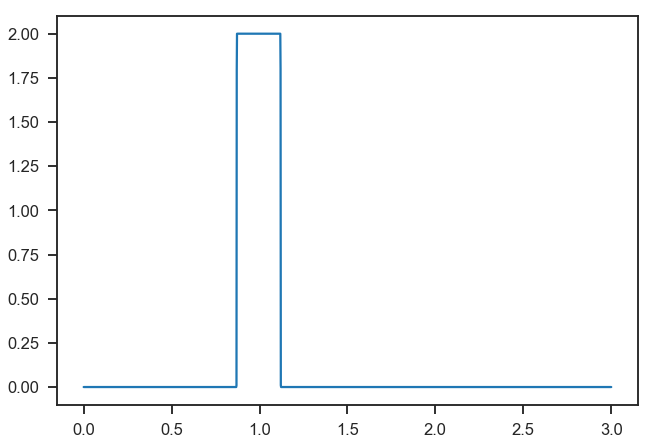

In [10]:
plot_sig(n_surface_0 = 2, n_surface_1 = 2, l = 5000, Z_x = np.linspace(0, 3, 2000),
             a = 1.12, b = 0.87,  drift = 2)

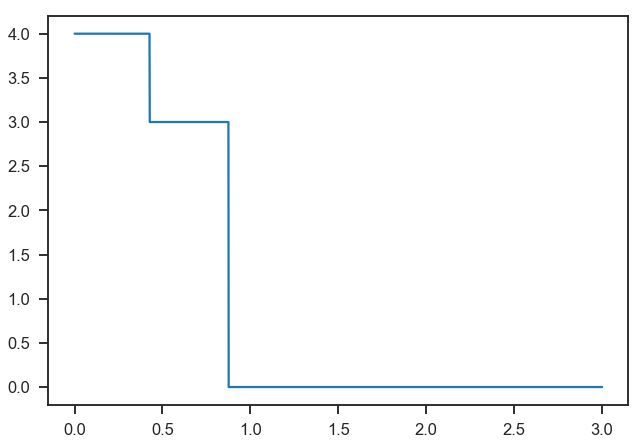

In [11]:
plot_sig(n_surface_0 = 3, n_surface_1 = -1, l = 50000, Z_x = np.linspace(0, 3, 2000),
             a = 0.8752, b = 0.4264,  drift = 3)

In [12]:
# Cleaning buffer
old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

# Computing model
gp.compute_model(geo_data)

# Black magic update
sys.stdout = old_stdout

# Split print strings
output = mystdout.getvalue().split('\n')

# Init parameters
n_surface_op_float_sigmoid = []
n_surface_0 = []
n_surface_1 = []
a = []
b = []
drift = []

for s in output:
    if 'n_surface_op_float_sigmoid __str__' in s:
        n_surface_op_float_sigmoid.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'n_surface_0 __str__' in s:
        n_surface_0.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'n_surface_1 __str__' in s:
        n_surface_1.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'a __str__' in s:
        a.append(float(s[s.find('= ')+2:]))
    if 'b __str__' in s:
        b.append(float(s[s.find('= ')+2:]))
    if 'drift[slice_init:slice_init+1][0] __str__' in s:
        drift.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))


a, b, n_surface_0, n_surface_1, drift

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))


([1.57395, 1.1252, 0.8752],
 [1.1252, 0.8752, 0.42645],
 [array([1.]), array([2.]), array([3.])],
 [array([1.]), array([2.]), array([-1.])],
 [array([1.]), array([2.]), array([3.])])

In [13]:
geo_data.solutions.scalar_field_matrix.max(), geo_data.solutions.scalar_field_matrix.min()

(1.5627, 0.4377)

In [14]:
geo_data.solutions.scalar_field_at_surface_points

array([[1.1252, 0.8752]])

In [15]:
def plot_sig(n_surface_0 , n_surface_1 , a , b, drift ,
             l = 50, Z_x = None, sf_max=None, sf_min=None, sf_at_scalar=None):
    if Z_x is None:
        Z_x = np.linspace(-3, 3, 2000)
    f_x_s = np.zeros_like(Z_x)
    
    if len(n_surface_0) == 1:

        f_x = -n_surface_0 / (1 + np.exp(-l * (Z_x - a))) - \
                       (n_surface_1 / (1 + np.exp(l * (Z_x - b)))) + drift
        plt.plot(f_x, Z_x)
    
    
    else:
        len_ = len(n_surface_0)
        fig = plt.figure(figsize=(7, 12))
        for e in range(len_):
            f_x = - n_surface_0[e] / (1 + np.exp(-l * (Z_x - a[e]))) - \
                    (n_surface_1[e] / (1 + np.exp(l * (Z_x - b[e])))) + drift[e]
            f_x_s += f_x
            #fig.add_subplot(len_, 1, e+1)
            plt.plot(f_x, Z_x, '--', label='Layer '+str(drift[e]))
        if sf_max is not None:
            plt.hlines(sf_max, 0, f_x_s.max(), label='Model Extent')
        if sf_min is not None:
            plt.hlines(sf_min, 0, f_x_s.max())
        if sf_at_scalar is not None:
            plt.hlines(sf_at_scalar, 0, f_x_s.max(), linewidth=3,
                       color=['#015482', '#9f0052'], label='Scalar value interfaces')
        
        plt.plot(f_x_s, Z_x, linewidth=5, alpha=.7, label='Actual exporty')
        plt.ylabel('Scalar field')
        plt.xlabel('Lith block')
      #  plt.gca().invert_yaxis()

        plt.legend(bbox_to_anchor=(1.8,1))

<IPython.core.display.Javascript object>


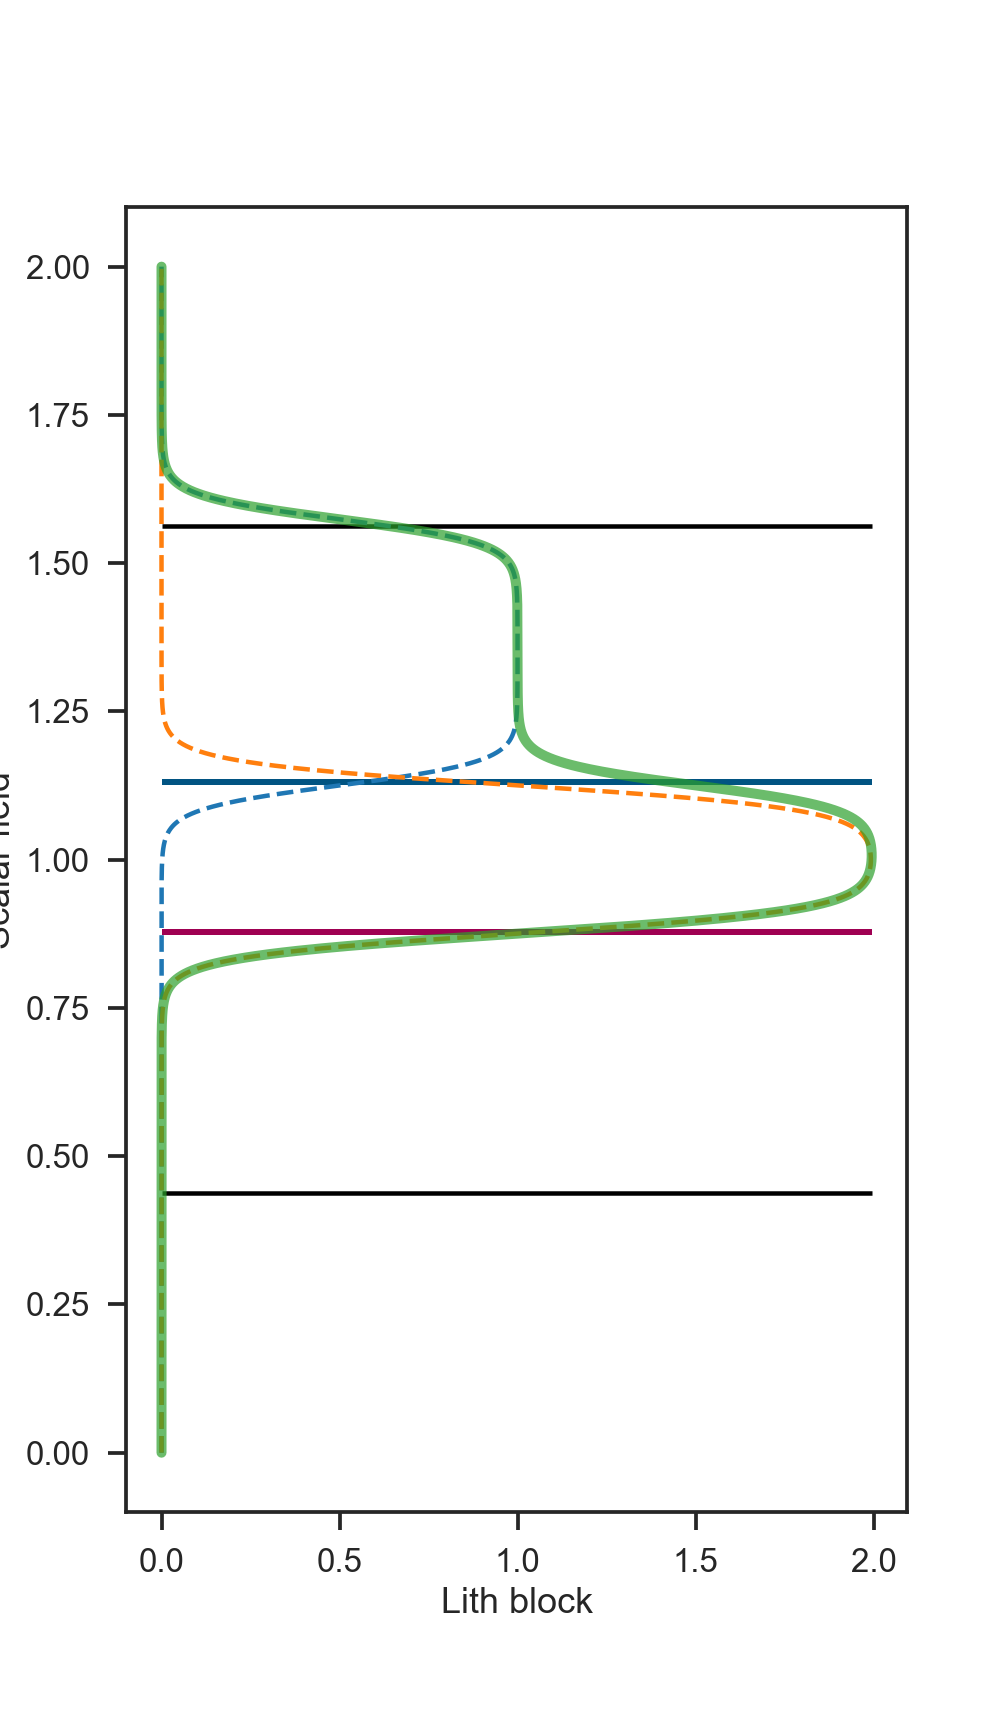

In [72]:
plot_sig(n_surface_0[:2], n_surface_1, a, b, drift, Z_x = np.linspace(0,2,2000),
         sf_max=1.5627, sf_min=0.4377, sf_at_scalar=geo_data.solutions.scalar_field_at_surface_points[0])

#### Lith block

<IPython.core.display.Javascript object>


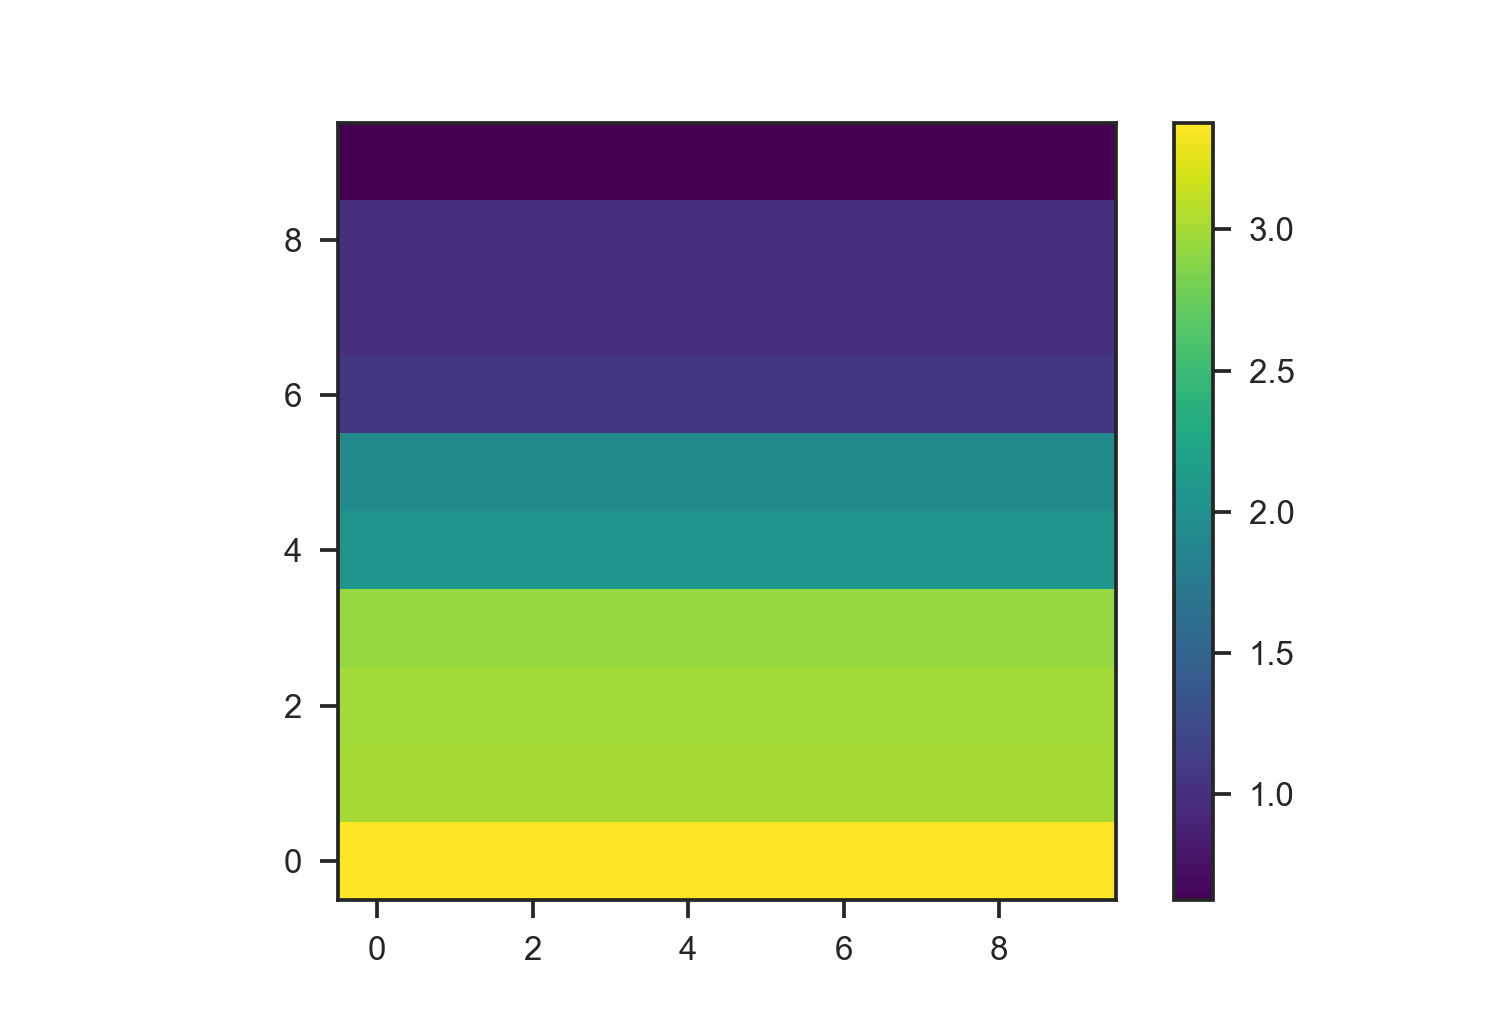

In [37]:
%matplotlib notebook
plt.imshow(geo_data.solutions.lith_block.reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
          origin='bottom', cmap='viridis')
plt.colorbar()

<IPython.core.display.Javascript object>


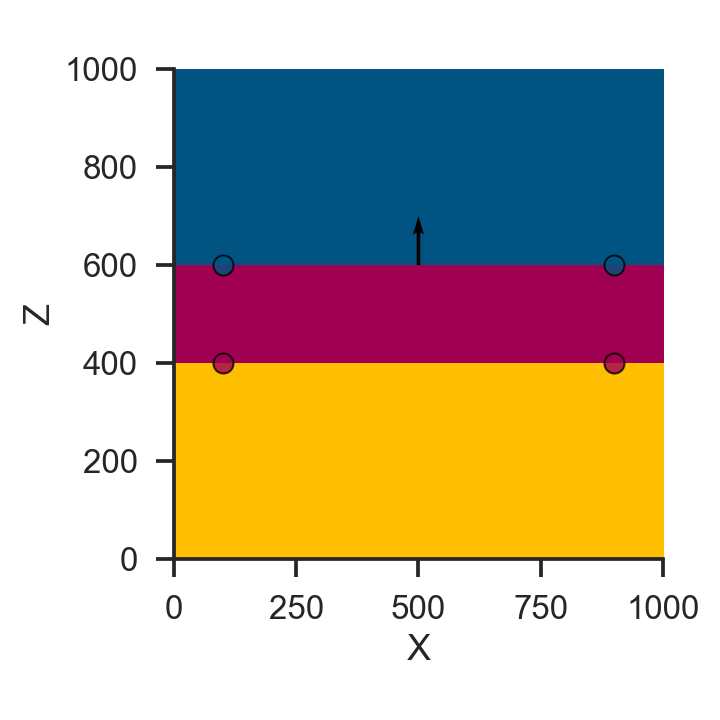

In [31]:
gp.plot.plot_section(geo_data, 0, show_data=True)

<IPython.core.display.Javascript object>


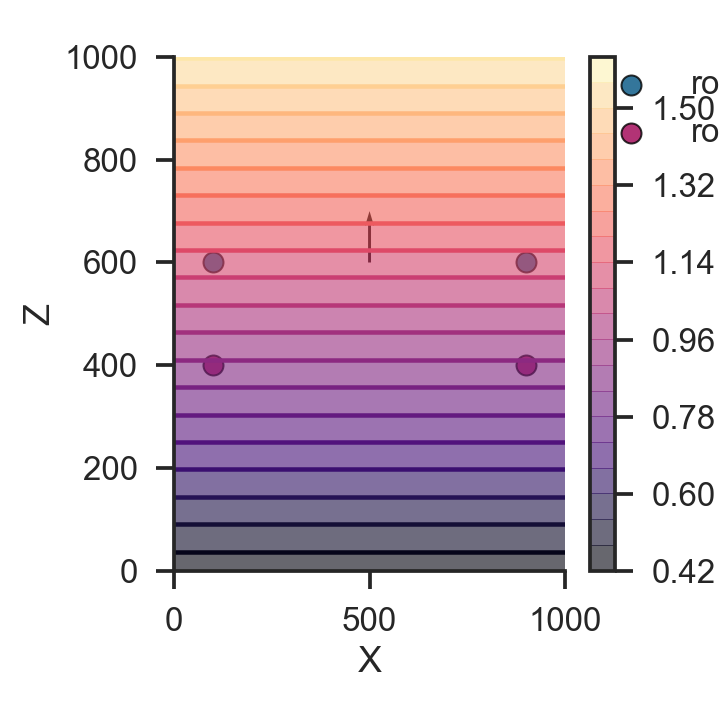

In [32]:
gp.plot.plot_scalar_field(geo_data, 0)
plt.colorbar()

### Calculating the value in a similar way to ensure comparison

In [45]:
th_f = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                      (geo_data.interpolator.theano_graph.compute_series()[0][-1]*1),
                          # mode=NanGuardMode(nan_is_error=True),
                         on_unused_input='ignore')

In [47]:
s = th_f(*geo_data.interpolator.get_python_input_block())

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]


In [51]:
s.shape

(104,)

<IPython.core.display.Javascript object>


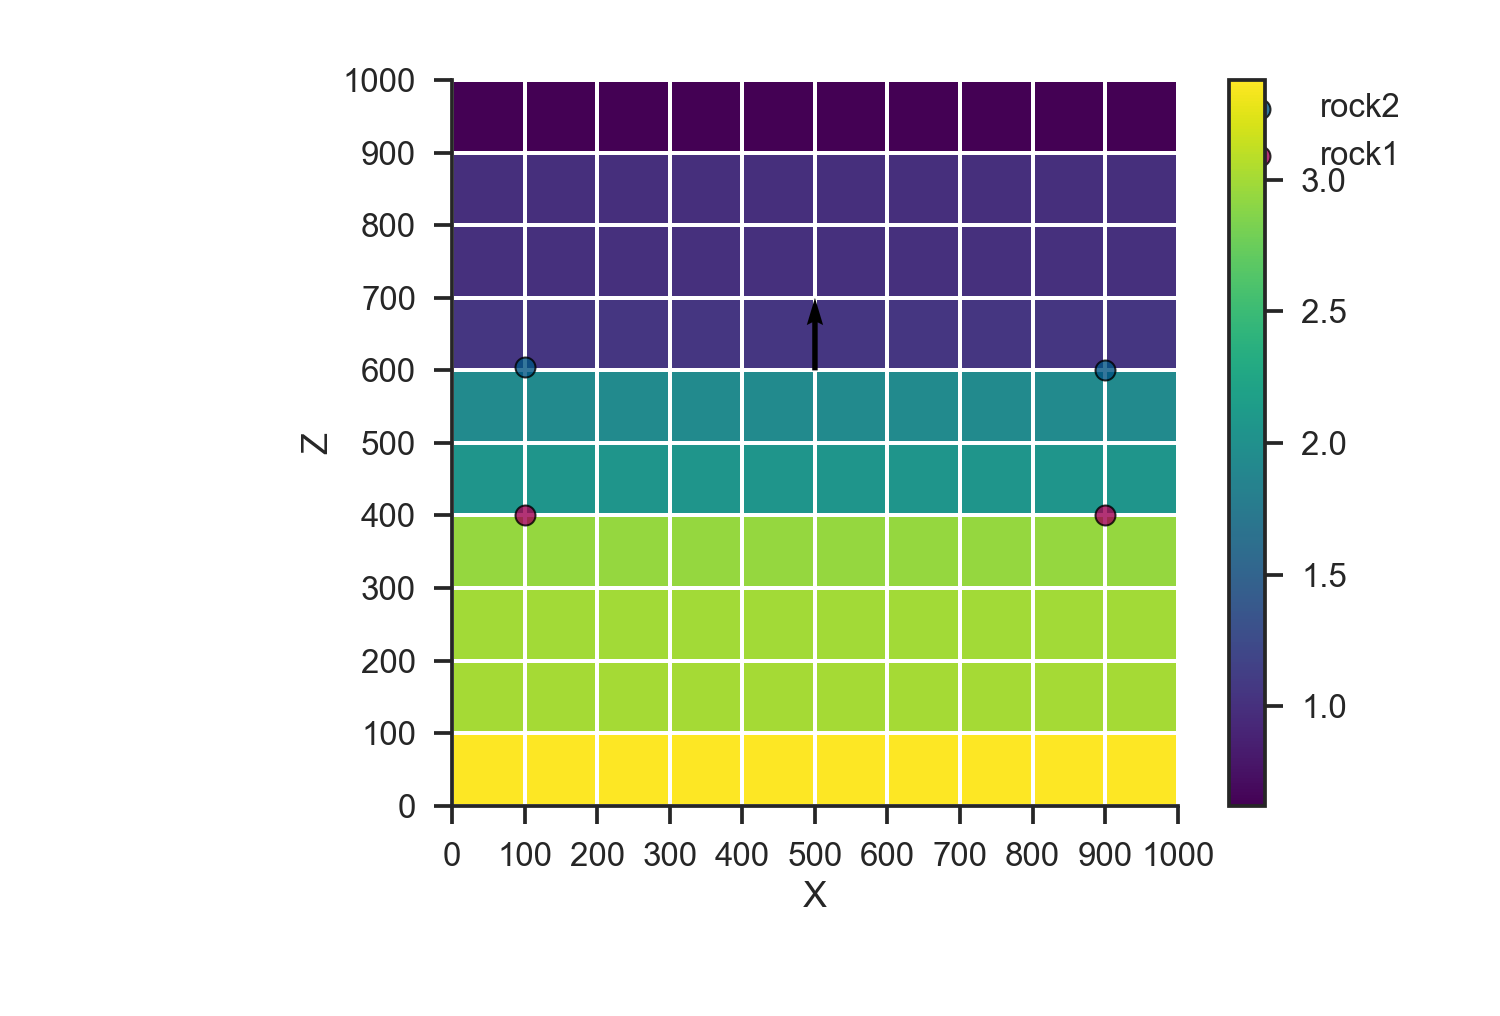

In [71]:
gp.plot.plot_data(geo_data)
plt.imshow(s[:100].reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
          origin='bottom', cmap='viridis', extent=(0,1000,0,1000))

ax = plt.gca();
ax.set_xticks(np.linspace(-0, 1000, 11));
ax.set_yticks(np.linspace(-0, 1000, 11));
ax.grid(color='w', linestyle='-', linewidth=2)

plt.colorbar()
# The row below the blue dot is 1.94

### Calculating the gradient

In [33]:
respect = geo_data.interpolator.theano_graph.input_parameters_loop[4]
th_f_g = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.grad((geo_data.interpolator.theano_graph.compute_series()[0][-1]*1).sum(), 
                                respect),
                          # mode=NanGuardMode(nan_is_error=True),
                         on_unused_input='ignore')
print("Respect: " + str(respect))


Respect: All the surface_points points at once


In [34]:
geo_data.interpolator.get_python_input_block()[4]

array([[0.2501, 0.5001, 0.5626],
       [0.7501, 0.5001, 0.5626],
       [0.2501, 0.5001, 0.4376],
       [0.7501, 0.5001, 0.4376]])

In [35]:
th_f_g(*geo_data.interpolator.get_python_input_block())

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0]

array([[    0.        ,     0.        ,  3426.67969412],
       [    0.        ,     0.        , -3328.27699107],
       [    0.        ,     0.        ,  1829.68984667],
       [    0.        ,     0.        , -1731.28714361]])

### Calculating the jacobian

In [23]:
respect = geo_data.interpolator.theano_graph.input_parameters_loop[4]
th_f_j = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.jacobian((geo_data.interpolator.theano_graph.compute_series()[0][-1]), 
                                respect),
                          # mode=NanGuardMode(nan_is_error=True),
                         on_unused_input='ignore')
print("Respect: " + str(respect))

Respect: All the surface_points points at once


In [24]:
jac = th_f_j(*geo_data.interpolator.get_python_input_block())

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0]

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0]

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1. 

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0]

n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] 

a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0]

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0]

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0]

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0]

a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]

n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1252
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8752
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42645
drift[slice_init:slice_init+1][0] __str__ = [[3.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1252
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8752
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.57395
n_surface_1 __str__ = [[1.]]
b __str__ = 1.12

In [25]:
jac.shape

(104, 4, 3)

In [26]:
jac[:100, 0, 2]

array([ 1.65675594e+02,  1.65360859e+00,  7.39346362e-03,  7.49143912e-01,
        1.43600592e+00,  4.60925807e+00,  5.31011558e+00,  3.28583603e-02,
        1.82810315e+00,  1.85430409e+02,  1.64814206e+02,  1.64331839e+00,
        5.99933040e-03,  3.55520351e-01,  9.42170202e-01,  4.01427400e+00,
        4.62455312e+00,  2.94057215e-02,  1.79333479e+00,  1.81778535e+02,
        1.64781232e+02,  1.64108996e+00,  5.39738893e-03,  1.09023633e-01,
        5.56353343e-01,  3.48089712e+00,  3.95456465e+00,  2.58450013e-02,
        1.75626588e+00,  1.77804978e+02,  1.65441851e+02,  1.64574899e+00,
        5.49342373e-03, -1.02381473e-03,  2.80358324e-01,  3.02321769e+00,
        3.32320783e+00,  2.23012047e-02,  1.71811217e+00,  1.73628962e+02,
        1.66564478e+02,  1.65506410e+00,  6.07307953e-03, -1.24011679e-02,
        8.96865122e-02,  2.63171103e+00,  2.73440906e+00,  1.88376117e-02,
        1.67974970e+00,  1.69356271e+02,  1.67849315e+02,  1.66602719e+00,
        6.82636037e-03,  

<IPython.core.display.Javascript object>


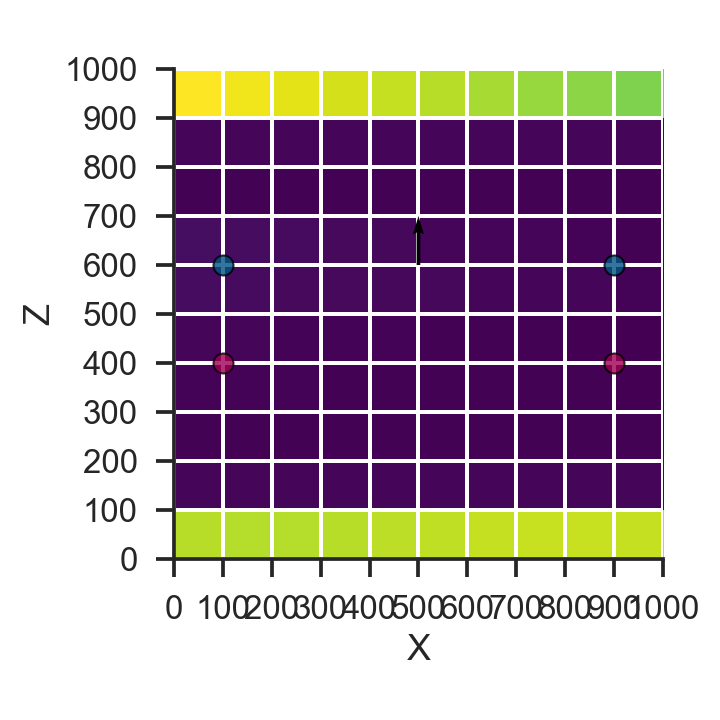

In [43]:
%matplotlib notebook
point = 0

gp.plot.plot_data(geo_data)
plt.imshow(jac[:100, point, 2].reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
          origin='bottom', cmap='viridis', extent=(0,1000,0,1000))

ax = plt.gca();
ax.set_xticks(np.linspace(-0, 1000, 11));
ax.set_yticks(np.linspace(-0, 1000, 11));
ax.grid(color='w', linestyle='-', linewidth=2)


<IPython.core.display.Javascript object>


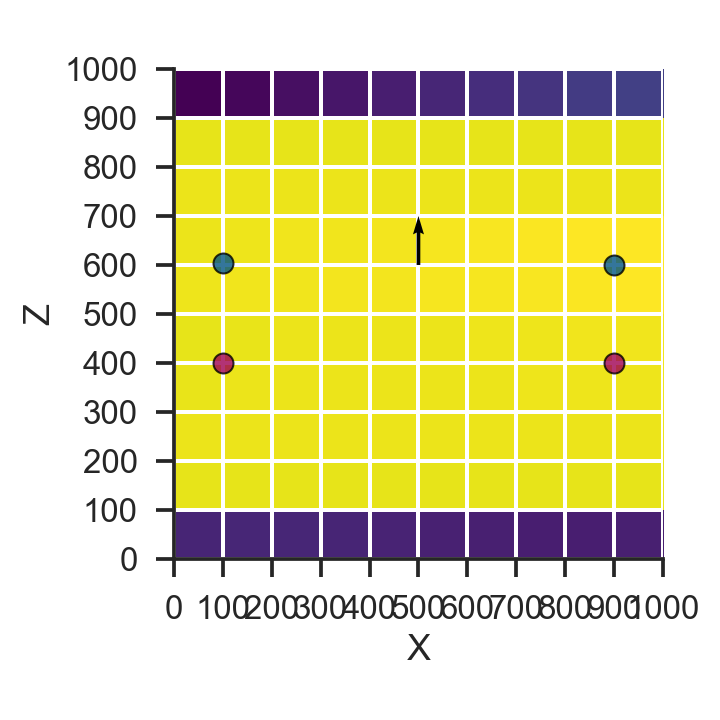

In [70]:
%matplotlib notebook
point = 1

gp.plot.plot_data(geo_data)
plt.imshow(jac[:100, point, 2].reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
          origin='bottom', cmap='viridis', extent=(0,1000,0,1000))

ax = plt.gca();
ax.set_xticks(np.linspace(-0, 1000, 11));
ax.set_yticks(np.linspace(-0, 1000, 11));
ax.grid(color='w', linestyle='-', linewidth=2)

### Differential derivative test:

In [53]:
geo_data.surface_points

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,100,500,600,0.2501,0.5001,0.5626,rock2,Default series,1,1,1.000000e-08
2,900,500,600,0.7501,0.5001,0.5626,rock2,Default series,1,1,1.000000e-08
6,100,500,400,0.2501,0.5001,0.4376,rock1,Default series,2,1,1.000000e-08
8,900,500,400,0.7501,0.5001,0.4376,rock1,Default series,2,1,1.000000e-08


In [65]:
geo_data.modify_surface_points(0, Z=605)

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,100,500,605.0,0.2501,0.5001,0.564163,rock2,Default series,1,1,1.000000e-08
2,900,500,600.0,0.7501,0.5001,0.561037,rock2,Default series,1,1,1.000000e-08
6,100,500,400.0,0.2501,0.5001,0.436037,rock1,Default series,2,1,1.000000e-08
8,900,500,400.0,0.7501,0.5001,0.436037,rock1,Default series,2,1,1.000000e-08


In [66]:
gp.compute_model(geo_data)

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2.  2.  3. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 1.5814226105241092
n_surface_1 __str__ = [[1.]]
b __str__ = 1.1303995455761846
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 1.1303995455761846
n_surface_1 __str__ = [[2.]]
b __str__ = 0.8773732894662896
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[3.]]
a __str__ = 0.8773732894662896
n_surface_1 __str__ = [[-1.]]
b __str__ = 0.42795361776748275
drift[slice_init:slice_init+1][0] __str__ = [[3.]]


../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))



Lithology ids 
  [3.36558468 3.00231452 2.99976106 2.94294129 2.06377214 1.95373811
 1.07827427 1.00034387 0.99847939 0.72686359 3.3630081  3.00228377
 2.99975663 2.94175373 2.06214483 1.95223633 1.07554501 1.0003289
 0.99840746 0.71717525 3.36293686 3.00227742 2.99975472 2.94100192
 2.06090264 1.95085312 1.07296396 1.00031411 0.99832711 0.70641085
 3.36495162 3.00229164 2.99975506 2.94066624 2.06002914 1.94963726
 1.07060758 1.0003     0.99824028 0.69486    3.36835302 3.00231988
 2.99975694 2.94063307 2.05943125 1.94857469 1.06847497 1.00028679
 0.99814862 0.68280519 3.37223439 3.00235326 2.99975934 2.94070718
 2.05893619 1.94756493 1.06646889 1.00027429 0.99805251 0.67045208
 3.37560486 3.00238164 2.99976113 2.94066194 2.05834002 1.94645923
 1.06445597 1.00026215 0.99795156 0.65796432 3.37754066 3.00239539
 2.99976135 2.94030306 2.05748618 1.94513831 1.06236152 1.00025023
 0.99784616 0.64556675 3.37732863 3.00238732 2.99975933 2.93950728
 2.05631337 1.9435602  1.06020809 1.00023875 

<IPython.core.display.Javascript object>


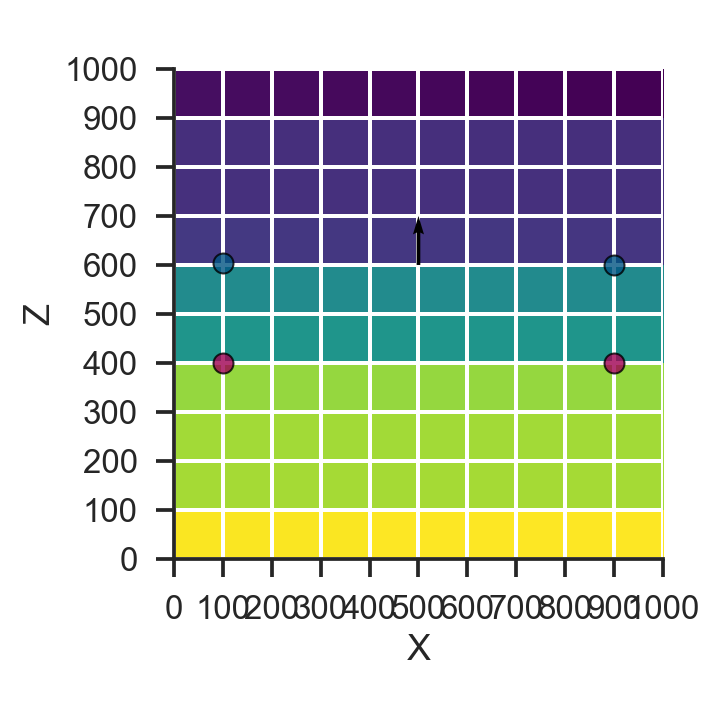

In [69]:
gp.plot.plot_data(geo_data)
plt.imshow(geo_data.solutions.lith_block[:100].reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
          origin='bottom', cmap='viridis', extent=(0,1000,0,1000))

ax = plt.gca();
ax.set_xticks(np.linspace(-0, 1000, 11));
ax.set_yticks(np.linspace(-0, 1000, 11));
ax.grid(color='w', linestyle='-', linewidth=2)

# The row below the blue dot is 1.94 for Index 0 Z = 600

----------